## Discretization

[Feature Engineering for Machine Learning Course](https://www.trainindata.com/p/feature-engineering-for-machine-learning)

Discretization is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretization is also called **binning**, where bin is an alternative name for interval.


### Discretization helps handle outliers and may improve the value spread in skewed variables

Discretization helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval or bucket. In addition, by creating appropriate bins or intervals, discretization can help spread the values of a skewed variable across a set of bins with an equal number of observations.


### Discretization approaches

There are several approaches to transform continuous variables into discrete ones. Discretization methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information other than the variable distribution to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretization methods

- Equal width discretisation
- Equal frequency discretization
- K-means discretization

#### Supervised discretization methods

- Discretization using decision trees


## Equal width discretization

Equal width discretization divides the scope of possible values into N bins of the same width. The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

width = (max value - min value) / N

where N is the number of bins or intervals.

For example, if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N; that is something to determine experimentally.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualWidthDiscretiser

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('../../Datasets/titanic.csv', usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and fare contain missing data, which I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

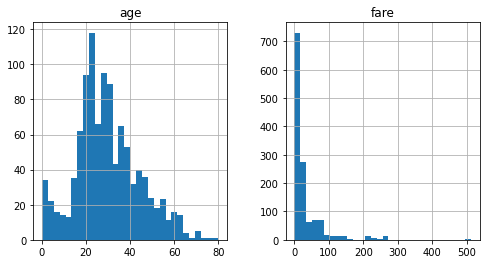

In [6]:
# let's explore the distribution of age

data[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal width discretisation with Feature-Engine

In [7]:
# with feature-engine we can automate the process for many variables
# in one line of code

disc = EqualWidthDiscretiser(bins=8, variables = ['age', 'fare'])

disc.fit(X_train)

EqualWidthDiscretiser(bins=8, variables=['age', 'fare'])

In [8]:
# in the binner dict, we can see the limits of the intervals. For age
# the value increases aproximately 9 years from one bin to the next.

# for fare it increases in around 60-70 dollars from one interval to the 
# next, but it increases always the same value, aka, same width.

disc.binner_dict_

{'age': [-inf,
  9.3958625,
  18.625024999999997,
  27.854187499999995,
  37.083349999999996,
  46.3125125,
  55.54167499999999,
  64.7708375,
  inf],
 'fare': [-inf,
  64.04115,
  128.0823,
  192.12345,
  256.1646,
  320.20575,
  384.2469,
  448.28805,
  inf]}

In [9]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [10]:
train_t.head()

,age,fare
501,1,0
588,0,0
402,3,0
1193,4,0
686,2,0


Text(0, 0.5, 'Number of observations per bin')

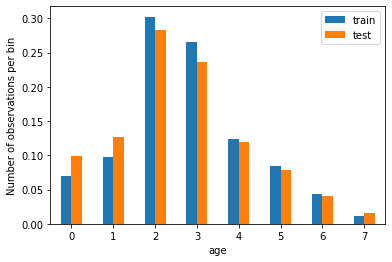

In [11]:
t1 = train_t['age'].value_counts(normalize=True).sort_index()
t2 = test_t['age'].value_counts(normalize=True).sort_index()

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

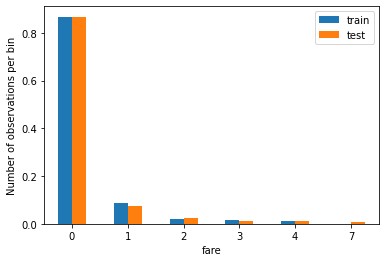

In [12]:
t1 = train_t['fare'].value_counts(normalize=True).sort_index()
t2 = test_t['fare'].value_counts(normalize=True).sort_index()

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

We can see quite clearly, that equal width discretization does not improve the value spread. The original variable Fare was skewed, and the discrete variable is also skewed.

### return boundaries instead of integers

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [14]:
disc = EqualWidthDiscretiser(
    bins=8,
    variables = ['age', 'fare'],
    return_boundaries=True,
)

disc.fit(X_train)

EqualWidthDiscretiser(bins=8, return_boundaries=True, variables=['age', 'fare'])

In [15]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [16]:
train_t.head()

,age,fare
501,"(9.396, 18.625]","(-inf, 64.041]"
588,"(-inf, 9.396]","(-inf, 64.041]"
402,"(27.854, 37.083]","(-inf, 64.041]"
1193,"(18.625, 27.854]","(-inf, 64.041]"
686,"(18.625, 27.854]","(-inf, 64.041]"


Text(0, 0.5, 'Number of observations per bin')

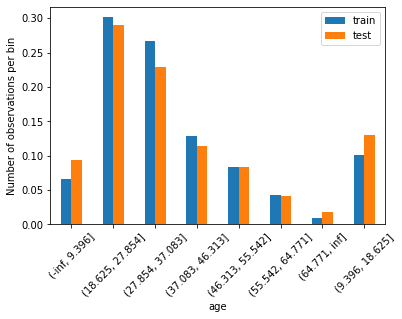

In [17]:
t1 = train_t['age'].value_counts(normalize=True).sort_index()
t2 = test_t['age'].value_counts(normalize=True).sort_index()

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')